In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from Zindi import *
from numpy.random import seed
seed(7)

In [2]:
X = np.load('train_ind_scaled_6m.npy').astype(np.float16)
y = np.load('train_labels.npy').astype(np.float16)

## Data Augmentation

In [3]:
#Generate new images rotated 90deg clockwise
Xaug1 = X.swapaxes(2,3)[:,:,:,::-1,:]
#generate new images rotated 180deg clockwise
Xaug2 = Xaug1.swapaxes(2,3)[:,:,:,::-1,:]
#Generate new images rotated 90deg counter-clockwise
Xaug3 = X.swapaxes(2,3)[:,:,::-1,:,:]

In [4]:
#Generate new images by 10px horizontal shift
Xaug4 = np.roll(X, 3, axis=2)
Xaug5 = np.roll(X, -3, axis=2)
#Generate new images by 10px vertical shift
Xaug6 = np.roll(X, 3, axis=3)
Xaug7 = np.roll(X, -3, axis=3)

In [5]:
#Stack all rotated inputs together, and labels.
Xaug = np.vstack((X, Xaug1, Xaug2, Xaug3, Xaug4, Xaug5, Xaug6, Xaug7))
yaug = np.hstack((y, y, y, y, y, y, y, y))
print("Augmented feature shape", Xaug.shape)
print("Augmented labels shape", yaug.shape)

Augmented feature shape (20416, 6, 40, 40, 27)
Augmented labels shape (20416,)


## Select only the 10 square pixels at the center

In [6]:
#Split Sentinel 2A channels and Terraclim channels (ignore QA60 channel from Sentinel)
#Select only B1, B5, B7 & B7 (all 4 calculated indices) from Sentinel 2A
#Select only pdsi, pr, tmmn, tmmx
X1_temp = Xaug[:,:,16:26,16:26,(0,1,9,10)]
X2_temp = Xaug[:,:,16:26,16:26,(16,18,23,24)]

In [7]:
#Shuffle augmented data once again
indices = np.arange(X1_temp.shape[0])
np.random.shuffle(indices)
X1_temp = X1_temp[indices]
X2_temp = X2_temp[indices]
y = yaug[indices]

In [8]:
#Terraclim values are same across pixels with rare differences. Lets takes only the mean values
X1 = np.mean(X1_temp, axis=(2,3))
X2 = np.mean(X2_temp, axis=(2,3))

In [9]:
print("X1 shape is: ", X1.shape)
print("X2 shape is: ", X2.shape)

X1 shape is:  (20416, 6, 4)
X2 shape is:  (20416, 6, 4)


In [10]:
#Split train, validation and test sets for Sentinel 2A channels
X1_train, y_train, X1_val, y_val, X1_test, y_test = train_val_test_split(X1, yaug, 200)

Train set shape:  (20016, 6, 4)
Train target shape:  (20016,)
Val set shape:  (200, 6, 4)
Val target shape:  (200,)
Test set shape:  (200, 6, 4)
Test target shape:  (200,)


In [11]:
#Split train, validation and test sets for Terraclim channels
X2_train, _, X2_val, _, X2_test, _ = train_val_test_split(X2, yaug, 200)

Train set shape:  (20016, 6, 4)
Train target shape:  (20016,)
Val set shape:  (200, 6, 4)
Val target shape:  (200,)
Test set shape:  (200, 6, 4)
Test target shape:  (200,)


## Build a GRU NN

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Flatten, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard

In [13]:
physical_devices = tf.config.list_physical_devices('GPU') 
physical_device = tf.config.experimental.list_physical_devices('GPU')
print("# of GPU's available: ", len(physical_device))
tf.config.experimental.set_memory_growth(physical_device[0], True)

# of GPU's available:  1


In [14]:
#Build a GRU model for Sentinel 2A channels
input_S2A = tf.keras.Input(shape=(None, 4))
gru_S2_1 = GRU(units=64,
               activation="tanh",
               kernel_initializer="glorot_uniform",
               return_sequences=True,
               dropout=0.25)(input_S2A)
batch_S2_1 = BatchNormalization()(gru_S2_1)
gru_S2_2 = GRU(units=128,
               activation="tanh",
               kernel_initializer="glorot_uniform",
               return_sequences=False,
               dropout=0.25)(batch_S2_1)
batch_S2_2 = BatchNormalization()(gru_S2_2)
flat_S2_1 = Flatten()(batch_S2_2)
drop_S2_1 = Dropout(rate=0.25, seed=99)(flat_S2_1)
dense_S2_1 = Dense(units=64, activation='relu')(drop_S2_1)

#Build an GRU model for Terraclim channels
input_TC = tf.keras.Input(shape=(None,4))
gru_TC_1 = GRU(units=32,
             activation="tanh",
             kernel_initializer="glorot_uniform",
             return_sequences=True,
             dropout=0.25)(input_TC)
batch_TC_1 = BatchNormalization()(gru_TC_1)
gru_TC_2 = GRU(units=64,
               activation="tanh",
               kernel_initializer="glorot_uniform",
               return_sequences=False,
               dropout=0.25)(batch_TC_1)
batch_TC_2 = BatchNormalization()(gru_TC_2)
drop_TC_1 = Dropout(rate=0.25, seed=99)(batch_TC_2)
dense_TC_1 = Dense(units=64, activation='relu')(drop_TC_1)

#Combine both model outputs
concat = Concatenate()([dense_S2_1, dense_TC_1])
dense_1 = Dense(units=32, activation='relu')(concat)
drop_1 = Dropout(rate=0.25, seed=99)(dense_1)
output = Dense(units=1, activation='linear')(drop_1)

model = tf.keras.Model([input_S2A, input_TC], output)

In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 64)     13440       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, 64)     256         gru[0][0]                        
_______________________________________________________________________________________

In [16]:
#Compile model
opt = Adam(learning_rate=0.02)
loss = MeanSquaredError()
model.compile(optimizer=opt, loss=loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [17]:
#Set learning rate with callbacks
LR_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
TB_cb = TensorBoard(log_dir='./logs')
#Fit model with history
history = model.fit([X1_train, X2_train], y_train, epochs=10, batch_size=30, callbacks=[LR_cb, TB_cb], validation_data=([X1_val, X2_val], y_val))

Epoch 1/10
  1/668 [..............................] - ETA: 0s - loss: 12.2029 - root_mean_squared_error: 3.4933WARNING:tensorflow:From C:\Users\Harish\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
668/668 [==============================] - 7s 10ms/step - loss: 3.3654 - root_mean_squared_error: 1.8345 - val_loss: 3.6756 - val_root_mean_squared_error: 1.9172
Epoch 2/10
668/668 [==============================] - 5s 8ms/step - loss: 2.9539 - root_mean_squared_error: 1.7187 - val_loss: 4.0952 - val_root_mean_squared_error: 2.0236
Epoch 3/10
668/668 [==============================] - 5s 8ms/step - loss: 2.9528 - root_mean_squared_error: 1.7184 - val_loss: 4.1305 - val_root_mean_squared_error: 2.0324
Epoch 4/10
668/668 [==============================] - 5s 8ms/step - loss: 2.9524 - root_mean_squared

In [18]:
model.evaluate([X1_test, X2_test], y_test)

7/7 [==============================] - 0s 3ms/step - loss: 3.4578 - root_mean_squared_error: 1.8595


[3.457827091217041, 1.8595232963562012]

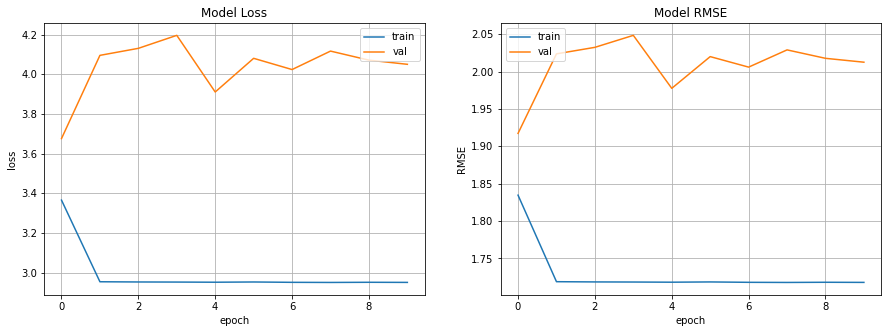

In [19]:
learning_plots(history)

## Results

This was a trial run to confirm GRU model does not have impact on the calculated indices. Overfitting seems common on all NN models. Next approach would be to determine other indices, evaluate the effect of rate of change of different indices and use a simpler model based on CART or SVM.